In [2]:
import pandas as pd 
import numpy as np 
import torch
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import sys
sys.path.append('..')
import glob
import os
import re
import plotly.graph_objects as go
import networkx as nx
import csv
from collections import defaultdict, Counter
import itertools as it
from pathlib import Path
import ast
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pickle
import prince
from light_famd import MFA
from sklearn.preprocessing import StandardScaler

In [3]:
path_to_networks = '../datasets/Networks/'
cell_lines = os.listdir(path_to_networks)
cell_lines = sorted(cell_lines)
print(cell_lines)
print('\n')
print(f'Total cell lines: {len(cell_lines)}')

['A375', 'A549', 'A673', 'AGS', 'ASC', 'BT20', 'CD34', 'CL34', 'CORL23', 'COV644', 'DV90', 'EFO27', 'FIBRNPC', 'H1299', 'HA1E', 'HCC15', 'HCC515', 'HCT116', 'HEC108', 'HEK293T', 'HEPG2', 'HL60', 'HS27A', 'HS578T', 'HT115', 'HT29', 'HUH7', 'JHUEM2', 'JURKAT', 'LOVO', 'MCF10A', 'MCF7', 'MDAMB231', 'MDST8', 'NCIH1694', 'NCIH1836', 'NCIH2073', 'NCIH508', 'NCIH596', 'NEU', 'NKDBA', 'NOMO1', 'NPC', 'OV7', 'PC3', 'PHH', 'PL21', 'RKO', 'RMGI', 'RMUGS', 'SKB', 'SKBR3', 'SKLU1', 'SKM1', 'SKMEL1', 'SKMEL28', 'SNGM', 'SNU1040', 'SNUC4', 'SNUC5', 'SW480', 'SW620', 'SW948', 'T3M10', 'THP1', 'TYKNU', 'U266', 'U937', 'VCAP', 'WSUDLCL2']


Total cell lines: 70


In [4]:
for cl in cell_lines:
    nets = 0
    for exp in os.listdir(path_to_networks + cl):
        path_exp = path_to_networks + cl + '/' + exp
        if os.path.isdir(path_exp + '/Results_CARNIVAL'):
            nets += 1
            
    print(f'Cell line {cl} has a total of {len(os.listdir(path_to_networks + cl))} experiments and {nets} CARNIVAL processed experiments.')


Cell line A375 has a total of 714 experiments and 714 CARNIVAL processed experiments.
Cell line A549 has a total of 482 experiments and 482 CARNIVAL processed experiments.
Cell line A673 has a total of 44 experiments and 44 CARNIVAL processed experiments.
Cell line AGS has a total of 37 experiments and 37 CARNIVAL processed experiments.
Cell line ASC has a total of 163 experiments and 163 CARNIVAL processed experiments.
Cell line BT20 has a total of 59 experiments and 59 CARNIVAL processed experiments.
Cell line CD34 has a total of 15 experiments and 15 CARNIVAL processed experiments.
Cell line CL34 has a total of 11 experiments and 11 CARNIVAL processed experiments.
Cell line CORL23 has a total of 6 experiments and 6 CARNIVAL processed experiments.
Cell line COV644 has a total of 1 experiments and 1 CARNIVAL processed experiments.
Cell line DV90 has a total of 8 experiments and 8 CARNIVAL processed experiments.
Cell line EFO27 has a total of 19 experiments and 19 CARNIVAL processed ex

# Connectivity Map Creator

In [5]:
MAX_ATOMS = 79
MAX_DEGREE = 21
BOND_FEATURES = 1

def connectivity_mat(reader, max_atoms, max_degree, num_bond_features):
    edge_mat = np.full((max_atoms, max_degree), fill_value=-1)
    bonds = np.full((max_atoms, max_degree), fill_value=0)
    
    node1, node2, bonds_mat, _ = node_bond_mat(reader)
    print(bonds_mat)
    for n1, b, n2 in zip(node1, bonds_mat, node2):
        for i in range(max_degree):
            if edge_mat[n1][i]==-1:
                edge_mat[n1][i]=n2
                bonds[n1][i] = b
                break
                
        for i in range(max_degree):       
            if edge_mat[n2][i] == -1:
                edge_mat[n2][i] = n1
                bonds[n2][i] = b
                break
    
    return edge_mat, bonds


with open(inter) as tsvfile:
    reader = csv.DictReader(tsvfile, dialect='excel-tab')
    edges, bonds = connectivity_mat(reader, 79, 21, 1)

NameError: name 'inter' is not defined

In [14]:
edges

array([[11, 57, 10, ..., -1, -1, -1],
       [43, -1, -1, ..., -1, -1, -1],
       [41, 45, 13, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [15]:
bonds

array([[ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 1, -1, -1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

# Find the max degree and max atoms of the whole dataset

In [58]:
def count_models(files):
    count = 0
    for f in files:
        inter = re.search('\A[i].*', f)
        if inter is not None:
            count += 1
            
    return count

def node_bond_mat(reader):
    node1 = []
    node2 = []
    bonds = []
    node_dict = {}
    
    for row in reader:
        if (row['Node1'] != 'Perturbation') and (row['Node2'] != 'Perturbation'):
            node1.append(row['Node1'])
            node2.append(row['Node2'])
            bonds.append(int(row['Sign']))
       
    for idx, node in enumerate(np.unique(node1 + node2)):
        node_dict[node] = idx
        max_atoms = idx
        
    node1 = [node_dict[node] for node in node1]
    node2 = [node_dict[node] for node in node2]
    
    return node1, node2, bonds, max_atoms

max_atoms_list = []
max_deg_list = []

def find_max(reader, curr_max_atoms, curr_max_degree):
    node1, node2, bonds, max_atoms = node_bond_mat(reader)
    max_atoms_list.append(max_atoms)
    
    if max_atoms > curr_max_atoms:
        curr_max_atoms = max_atoms
    
    max_degree = max(Counter(node1 + node2).values())
    max_deg_list.append(max_degree)
    if max_degree > curr_max_degree:
        curr_max_degree = max_degree
    
    return curr_max_atoms, curr_max_degree

all_nets = defaultdict(list)

def run_max_test():
    max_degree = 0
    max_atoms = 0
    for cl in cell_lines:
        full_path = path_to_networks + cl + '/'
        list_dir = sorted(os.listdir(path_to_networks + cl))
        total_exp = len(os.listdir(path_to_networks + cl))
        repeat_dir = np.repeat(full_path, total_exp)

        full_dir = [x + y for x,y in zip(repeat_dir, list_dir)]

        all_nets[cl] = full_dir

        sample = all_nets[cl]
        print('#####################################################################################')
        print(f"############################# Cell Line {cl}. #######################################")
        print('#####################################################################################')
        for exp in sample:
            if os.path.isdir(exp + '/Results_CARNIVAL'):
                files = os.listdir(exp + '/Results_CARNIVAL')
                files = np.array(sorted(files))
                files = np.delete(files, [0,1], 0)
                files = files[(files != 'results_CARNIVAL.Rdata') & (files != 'weightedModel_1.txt') & (files != 'nodesAttributes_1.txt')]
                count = count_models(files)
                for c in range(1, count+1):
                    inter = exp + '/Results_CARNIVAL/' + f'interactions_1_model{c}.tsv'
                    if os.path.exists(inter):
                        with open(inter) as tsvfile:
                            reader = csv.DictReader(tsvfile, dialect='excel-tab')
                            max_atoms, max_degree = find_max(reader, max_atoms, max_degree)
                            
                print(f'Experiment: {exp}')
                print(f'Counted {count} models in file.')
                print(f'Current Max Atoms: {max_atoms}')
                print(f'Current Max Degree: {max_degree}')

In [59]:
run_max_test()

#####################################################################################
############################# Cell Line A375. #######################################
#####################################################################################
Experiment: ../datasets/Networks/A375/BRAF001_A375_24H:BRD-K09951645-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 61
Current Max Degree: 10
Experiment: ../datasets/Networks/A375/BRAF001_A375_24H:BRD-U73308409-000-01-9:2.5
Counted 100 models in file.
Current Max Atoms: 61
Current Max Degree: 10
Experiment: ../datasets/Networks/A375/BRAF001_A375_6H:BRD-K16478699-001-05-0:10
Counted 71 models in file.
Current Max Atoms: 70
Current Max Degree: 11
Experiment: ../datasets/Networks/A375/BRAF001_A375_6H:BRD-K36862742-001-19-9:10
Counted 5 models in file.
Current Max Atoms: 70
Current Max Degree: 11
Experiment: ../datasets/Networks/A375/BRAF001_A375_6H:BRD-K79602928-003-13-2:10
Counted 39 models in file.
Current Max Atoms: 70
C

Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K20152659-001-02-0:10
Counted 100 models in file.
Current Max Atoms: 73
Current Max Degree: 17
Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K21680192-300-06-0:10
Counted 100 models in file.
Current Max Atoms: 73
Current Max Degree: 17
Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K32828673-002-03-9:10
Counted 100 models in file.
Current Max Atoms: 73
Current Max Degree: 17
Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K39520573-001-01-2:10
Counted 77 models in file.
Current Max Atoms: 73
Current Max Degree: 17
Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K40624912-003-02-3:10
Counted 6 models in file.
Current Max Atoms: 73
Current Max Degree: 17
Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K47150025-001-01-2:10
Counted 2 models in file.
Current Max Atoms: 73
Current Max Degree: 17
Experiment: ../datasets/Networks/A375/CPC005_A375_24H:BRD-K48735772-001-01-4:10
Counted

Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K68065987-300-03-4:10
Counted 100 models in file.
Current Max Atoms: 73
Current Max Degree: 19
Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K68143200-001-05-9:10
Counted 94 models in file.
Current Max Atoms: 73
Current Max Degree: 19
Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K69328504-001-01-7:10
Counted 7 models in file.
Current Max Atoms: 73
Current Max Degree: 19
Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K69840642-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 73
Current Max Degree: 19
Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K69932463-001-03-1:10
Counted 74 models in file.
Current Max Atoms: 73
Current Max Degree: 19
Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K73395020-001-01-5:10
Counted 1 models in file.
Current Max Atoms: 73
Current Max Degree: 19
Experiment: ../datasets/Networks/A375/CPC006_A375_24H:BRD-K74236984-001-01-4:10
Counted 

Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K27484191-001-07-4:10
Counted 93 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K32501161-003-07-0:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K32821942-001-12-2:10
Counted 28 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K32862555-001-04-1:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K33305493-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K39345836-001-05-8:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC007_A375_24H:BRD-K49630153-001-05-6:10
Coun

Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K28040935-019-01-9:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K29506255-019-01-0:10
Counted 5 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K32636001-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K32944375-019-01-3:10
Counted 12 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K33720394-001-01-1:10
Counted 2 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K38061943-019-01-3:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC008_A375_6H:BRD-K40329609-019-01-5:10
Counted 20 mod

Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-A44133049-003-04-5:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-A68888262-003-12-8:10
Counted 85 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-A93659613-051-05-1:10
Counted 27 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-A96107863-001-10-0:10
Counted 10 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-K02227374-003-04-8:10
Counted 2 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-K04710043-001-14-5:10
Counted 1 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC011_A375_6H:BRD-K09471561-001-15-8:10
Counted 57 model

Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K30993697-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K32010074-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K32896438-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K35004659-001-01-8:10
Counted 4 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K36087356-001-01-8:10
Counted 1 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K42308740-001-01-5:10
Counted 10 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC012_A375_6H:BRD-K45842176-001-01-3:10
Counted 49 mod

Experiment: ../datasets/Networks/A375/CPC013_A375_6H:BRD-K85266146-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC013_A375_6H:BRD-K86761848-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC013_A375_6H:BRD-K94493764-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC013_A375_6H:BRD-U37049823-000-01-2:10
Counted 2 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC013_A375_6H:BRD-U68942961-000-01-2:10
Counted 2 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC013_A375_6H:BRD-U82589721-000-01-4:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-A06929388-001-01-1:10
Counted 100 m

Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-U08759356-000-01-6:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-U29336476-000-01-3:10
Counted 9 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-U33728988-000-01-6:10
Counted 100 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-U43867373-000-01-3:10
Counted 1 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-U51951544-000-01-8:10
Counted 80 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC014_A375_6H:BRD-U86922168-000-01-3:10
Counted 1 models in file.
Current Max Atoms: 76
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC015_A375_6H:BRD-A01320529-001-05-9:10
Counted 100 mode

Experiment: ../datasets/Networks/A375/CPC017_A375_6H:BRD-K60230970-001-04-3:10
Counted 65 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC017_A375_6H:BRD-K76674262-001-01-7:10
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC017_A375_6H:BRD-K94176593-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC018_A375_6H:BRD-A15914070-001-01-5:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC018_A375_6H:BRD-A28970875-300-03-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC018_A375_6H:BRD-A40431293-001-01-0:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC018_A375_6H:BRD-A50311610-300-06-2:10
Counted 1 models

Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K66788707-001-07-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K71199328-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K72732164-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K79390395-001-07-4:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K81128206-003-21-0:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K82381502-003-19-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/CPC020_A375_6H:BRD-K88868628-001-01-0:10
Counted 100

Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K27305650:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K29423519:9.37945
Counted 3 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K41335306:9.98187
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K43357772:9.94639
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K44242139:10.0633
Counted 81 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K44732214:10.0665
Counted 20 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A375/DOSBIO002_A375_24H:BRD-K67236950:10.6884
Counted 1 models i

Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-A47513740-001-02-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-A63998256-001-02-3:10
Counted 6 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-A72711497-236-02-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-A78360835-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-A81772229-001-01-6:10
Counted 17 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-A83855350-003-01-4:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC005_A549_24H:BRD-K13571841-001-04-5:10
Counted

Experiment: ../datasets/Networks/A549/CPC007_A549_24H:BRD-K60870698-001-08-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC007_A549_24H:BRD-K71265179-001-07-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC007_A549_24H:BRD-K84203638-001-05-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC007_A549_6H:BRD-A09719808-001-02-3:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC007_A549_6H:BRD-A58924247-001-08-5:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC007_A549_6H:BRD-A76490030-001-09-4:10
Counted 21 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC007_A549_6H:BRD-K19499941-001-09-1:10
Counted 100

Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K18724229-019-01-5:10
Counted 46 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K18726304-019-01-8:10
Counted 17 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K19724398-019-01-9:10
Counted 13 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K26304855-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K28366633-001-05-2:10
Counted 71 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K40373196-001-04-4:10
Counted 84 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC009_A549_6H:BRD-K51443908-001-03-2:10
Counted 100 mo

Experiment: ../datasets/Networks/A549/CPC012_A549_6H:BRD-K96640811-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC013_A549_24H:BRD-K09854848-001-01-0:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC013_A549_24H:BRD-K18163752-001-01-9:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC013_A549_24H:BRD-K19166598-001-01-9:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC013_A549_24H:BRD-K48950795-001-01-2:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC013_A549_24H:BRD-K69852452-001-01-8:10
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC013_A549_24H:BRD-K77987635-001-01-2:10
Counted 99 mo

Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-A63667919-103-01-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-A68929948-001-01-9:10
Counted 49 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-A94669766-001-04-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-K04146668-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-K06543683-066-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-K07762753-001-02-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC016_A549_6H:BRD-K12513978-001-16-7:10
Counted 13

Experiment: ../datasets/Networks/A549/CPC018_A549_24H:BRD-K21064560-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC018_A549_24H:BRD-K73395020-001-01-5:10
Counted 93 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC018_A549_6H:BRD-A71459254-001-02-8:10
Counted 67 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC018_A549_6H:BRD-K12244279-001-02-5:10
Counted 60 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC018_A549_6H:BRD-K23583188-001-06-4:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC018_A549_6H:BRD-K63606607-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/CPC019_A549_24H:BRD-A00420644-001-01-7:10
Counted 1

Experiment: ../datasets/Networks/A549/DOS045_A549_24H:BRD-K76856691-001-01-1:5.02
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/DOS045_A549_24H:BRD-K90805324-001-01-5:4.91
Counted 32 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/DOS045_A549_24H:BRD-K94781393-001-01-0:5.02
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/DOS047_A549_24H:BRD-K75813018-001-01-9:4.99
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/DOS047_A549_24H:BRD-K95208083-001-01-8:5.01
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/DOS048_A549_24H:BRD-K16782389-001-01-9:4.95
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/DOS054_A549_24H:BRD-K05639721-001

Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-A28105619-001-01-3:10
Counted 12 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-A36630025-001-02-6:11.1
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-A45889380-300-04-8:10
Counted 22 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-A52650764-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-A61304759-001-01-0:3.33
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-K16406336-311-01-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A549/HOG001_A549_24H:BRD-K59369769-001-05-4:10


Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K01877528-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K01976263-003-04-5:0.63
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K02822062-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K03618428-001-01-3:22.2
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K04010869-001-02-6:1
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K04853698-003-01-4:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/A673/CPC006_A673_6H:BRD-K06792661-001-01-9:10
Counted 

Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K49371609-310-01-1:0.09
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K64890080-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K69840642-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K71726959-001-06-7:122.55
Counted 68 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K73261812-001-01-1:10
Counted 21 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K74148702-001-03-8:48
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/AGS/CPC006_AGS_6H:BRD-K74305673-001-01-3:10
Counted 65 models in 

Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K46056750-001-01-3:10
Counted 36 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K50140147-001-03-6:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K51967704-001-01-0:10
Counted 68 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K58347372-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K63068307-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K64606589-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC013_ASC_24H:BRD-K66254772-001-01-3:10
Counted 1 models i

Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-A68930007-001-03-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-A73909368-001-01-5:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-A95513702-001-03-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-K04548931-003-05-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-K15834839-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-K17705806-003-01-0:10
Counted 71 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC015_ASC_24H:BRD-K22503835-001-06-0:10
Counted 12 models i

Experiment: ../datasets/Networks/ASC/CPC018_ASC_24H:BRD-K59256312-066-04-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC018_ASC_24H:BRD-K63606607-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC018_ASC_24H:BRD-K74305673-001-02-1:10
Counted 7 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/ASC/CPC018_ASC_24H:BRD-K84595254-001-03-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
#####################################################################################
############################# Cell Line BT20. #######################################
#####################################################################################
Experiment: ../datasets/Networks/BT20/LJP001_BT20_24H:BRD-A45498368-001-03-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Ma

Experiment: ../datasets/Networks/BT20/LJP002_BT20_24H:BRD-K43389698-001-03-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/BT20/LJP002_BT20_24H:BRD-K53281329-001-01-9:10
Counted 20 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/BT20/LJP002_BT20_24H:BRD-K67868012-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/BT20/LJP002_BT20_24H:BRD-K72414522-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/BT20/LJP002_BT20_6H:BRD-K40738845-001-01-9:2
Counted 64 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/BT20/LJP002_BT20_6H:BRD-K50387473-001-03-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
#####################################################################################
#

Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-A45889380-300-04-8:10
Counted 93 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-K00615600-001-06-1:25
Counted 50 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-K01976263-003-04-5:0.63
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-K06792661-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-K15025317-001-05-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-K17140735-300-02-4:11.1
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/EFO27/CPC006_EFO27_6H:BRD-K49371609-310-0

Experiment: ../datasets/Networks/FIBRNPC/NMH002_FIBRNPC_24H:BRD-K43571060-001-06-8:10
Counted 46 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/FIBRNPC/NMH002_FIBRNPC_24H:BRD-K45528773-001-04-9:10
Counted 50 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/FIBRNPC/NMH002_FIBRNPC_24H:BRD-K51704689-001-04-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/FIBRNPC/NMH002_FIBRNPC_24H:BRD-K51966546-001-02-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/FIBRNPC/NMH002_FIBRNPC_24H:BRD-K52313696-001-09-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/FIBRNPC/NMH002_FIBRNPC_24H:BRD-K52522949-001-02-5:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/FIBRNPC/NMH002_FI

Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K11927976-050-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K14618467-003-01-8:10
Counted 62 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K26669427-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K40919711-001-02-4:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K52850071-001-01-2:10
Counted 16 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K67860401-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC001_HA1E_6H:BRD-K68336408-001-03-4:10
Counted 100

Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-A84174393-236-03-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-A93236127-001-03-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-A94756469-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-K04548931-003-05-8:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-K06543683-066-01-3:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-K14920963-304-01-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC004_HA1E_6H:BRD-K33818169-003-01-2:10
Counted 13 mo

Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K03618428-001-01-3:22.2
Counted 36 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K05649647-001-03-7:20
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K06792661-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K06980535-003-15-0:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K13049116-001-01-6:10
Counted 6 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K14696368-001-01-8:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K16406336-311-01-2:10
Counted

Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-K99696746-004-03-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_24H:BRD-U88459701-000-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_6H:BRD-A18763547-300-04-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_6H:BRD-A36275421-001-11-1:10
Counted 41 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_6H:BRD-A79465854-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_6H:BRD-K09499853-305-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC006_HA1E_6H:BRD-K12502280-001-01-5:11.1
Counte

Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K26300881-001-03-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K26304855-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K27721098-001-07-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K28366633-001-05-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K34711351-001-01-0:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K36354764-001-04-2:10
Counted 16 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC009_HA1E_6H:BRD-K39580048-001-04-7:10
Counted 100 

Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-A02333338-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-A32161980-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-A70591769-001-01-9:10
Counted 28 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-A75931230-001-03-9:10
Counted 5 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-A89333723-001-01-0:10
Counted 3 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-K04833372-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC013_HA1E_6H:BRD-K11636097-001-01-5:10
Counted 100 mo

Experiment: ../datasets/Networks/HA1E/CPC014_HA1E_6H:BRD-U43867373-000-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC014_HA1E_6H:BRD-U51951544-000-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC014_HA1E_6H:BRD-U86922168-000-01-3:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC014_HA1E_6H:BRD-U87780043-000-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC019_HA1E_6H:BRD-A94377914-001-02-7:10
Counted 3 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC019_HA1E_6H:BRD-K17953061-001-05-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/CPC019_HA1E_6H:BRD-K31688005-001-01-3:10
Counted 21 mo

Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K02130563:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K19876534:10
Counted 35 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K39569857:10
Counted 19 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K45330754:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K52313696:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K55533488:3.33
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HA1E/PCLB002_HA1E_24H:BRD-K59369769:10
Counted 100 models in file.
Current Max Atoms: 78
Current Ma

Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K67868012-003-01-5:11.1
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K68548958-001-01-2:20
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K69840642-001-01-4:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K69932463-001-03-1:10
Counted 30 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K73395020-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K74148702-001-03-8:48
Counted 31 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC15/CPC006_HCC15_6H:BRD-K78659596-001-01-3:

Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K06159959-001-01-2:10
Counted 18 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K08554278-001-02-4:10
Counted 5 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K08996725-313-01-7:10
Counted 30 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K08998509-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K11163873-001-02-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K13032584-003-03-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC003_HCC515_6H:BRD-K225038

Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K47717570-304-01-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K49945136-001-03-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K51662849-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K52219182-001-01-6:10
Counted 32 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K53220666-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K54771420-001-03-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC004_HCC515_6H:BRD-K600

Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K69328504-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K69840642-001-01-4:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K69932463-001-03-1:10
Counted 57 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K81647657-001-01-9:10
Counted 16 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K86574132-001-04-9:48
Counted 69 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K92991072-001-02-3:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC006_HCC515_24H:BRD-K94

Experiment: ../datasets/Networks/HCC515/CPC009_HCC515_6H:BRD-K71917235-001-01-9:10
Counted 91 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC009_HCC515_6H:BRD-K79222491-001-01-5:10
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC009_HCC515_6H:BRD-K81814927-001-01-9:10
Counted 26 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC010_HCC515_6H:BRD-A18411371-001-10-6:10
Counted 7 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC010_HCC515_6H:BRD-A18725729-001-08-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC010_HCC515_6H:BRD-A37735495-001-10-6:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC010_HCC515_6H:BRD-A61825514

Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K80786583-001-01-5:10
Counted 72 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K83643280-001-01-1:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K85266146-001-01-3:10
Counted 3 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K86631041-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K87909389-001-02-0:10
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K89558221-001-01-7:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/CPC013_HCC515_6H:BRD-K89784888-00

Experiment: ../datasets/Networks/HCC515/PCLB002_HCC515_24H:BRD-K99636700:10
Counted 83 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/PCLB003_HCC515_24H:BRD-A36275421-001-06-1:10
Counted 66 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/PCLB003_HCC515_24H:BRD-K03641750-001-01-3:0.04
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/PCLB003_HCC515_24H:BRD-K24576554-001-01-4:10
Counted 1 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/PCLB003_HCC515_24H:BRD-K25079130-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/PCLB003_HCC515_24H:BRD-K42573370-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HCC515/PCLB003_HCC515_24H:BRD-

Experiment: ../datasets/Networks/HEK293T/BRAF001_HEK293T_24H:BRD-A96407378-001-12-8:10
Counted 6 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEK293T/BRAF001_HEK293T_24H:BRD-K09951645-001-02-7:0.625
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEK293T/BRAF001_HEK293T_24H:BRD-K16478699-001-05-0:10
Counted 2 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEK293T/BRAF001_HEK293T_24H:BRD-K23984367-001-04-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEK293T/BRAF001_HEK293T_24H:BRD-K79602928-003-13-2:10
Counted 58 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEK293T/BRAF001_HEK293T_24H:BRD-K81418486-001-15-2:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEK293T/B

Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K76907295-001-03-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K77547509-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K80822897-001-05-0:10
Counted 66 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K89059493-001-01-7:10
Counted 33 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K92158425-001-01-5:10
Counted 4 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K93060291-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC008_HEPG2_6H:BRD-K97936712-001-01-1:10

Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K11795542-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K13390322-001-01-4:10
Counted 52 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K15592317-001-01-0:10
Counted 58 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K15600710-066-01-7:10
Counted 36 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K17743125-001-03-5:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K19166598-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC013_HEPG2_6H:BRD-K25504083-001-03-1:1

Experiment: ../datasets/Networks/HEPG2/CPC015_HEPG2_6H:BRD-A41145729-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC015_HEPG2_6H:BRD-A73909368-001-01-5:10
Counted 12 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC015_HEPG2_6H:BRD-K22503835-001-06-0:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC015_HEPG2_6H:BRD-K92093830-003-05-0:10
Counted 8 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC015_HEPG2_6H:BRD-K98490050-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC016_HEPG2_6H:BRD-A30437061-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 78
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC016_HEPG2_6H:BRD-A35588707-001-03-0:1

Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K34363599-001-02-0:10
Counted 94 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K48803730-001-01-1:10
Counted 14 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K58479490-001-02-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K64754843-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K69159985-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K74155249-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CPC019_HEPG2_6H:BRD-K90417362-001-01-2:

Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-K51674646-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-K52785744-001-01-7:10.1671
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-K53523901-001-01-0:2.5
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-K55082668-001-01-8:9.9402
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-K55468218-001-16-2:10
Counted 7 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-K55851396-001-01-5:9.7843
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/CVD001_HEPG2_24H:BRD-

Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-A19500257-001-01-3:10
Counted 53 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-K21001652-001-01-7:10
Counted 18 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-K24576554-001-01-4:10
Counted 59 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-K25079130-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-K50324045-001-01-3:10
Counted 15 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-K56411643-001-02-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HEPG2/PCLB003_HEPG2_24H:BRD-K641061

Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K50199947-001-01-8:0.08
Counted 62 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K53414658-001-04-1:10
Counted 20 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K57080016-001-08-4:0.4
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K58772419-001-04-7:10
Counted 90 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K63923597-001-06-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K64800655-001-03-3:10
Counted 22 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HS578T/LJP001_HS578T_6H:BRD-K668

Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K30707190-001-02-5:80
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K68997413-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K73789395-001-06-5:102.71
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K74148702-001-03-8:48
Counted 55 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K77947974-001-05-6:4.21
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K81418486:10
Counted 79 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT115/CPC006_HT115_6H:BRD-K92980438-001-01-7:160

Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A38030642-001-02-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A43331270-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A47829399-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A62182663-001-01-4:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A62809825-001-01-7:10
Counted 95 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A68631409-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-A84481105-003-17-2:10
Count

Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K86574132-001-04-9:48
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K90382497-001-03-2:10
Counted 14 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K90999434-003-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K91623615-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K92317137-001-04-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K92991072-001-02-3:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC006_HT29_24H:BRD-K94325918-001-03-8:10
Count

Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K44432556-001-03-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K54687541-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K58247702-001-01-2:10
Counted 44 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K58853583-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K59470558-003-02-8:10
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K63308290-019-01-5:10
Counted 86 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC008_HT29_6H:BRD-K64058329-001-04-2:10
Counted 38 mo

Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K19624190-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K19875179-001-01-2:10
Counted 37 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K21672423-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K26257340-001-02-6:10
Counted 32 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K26818574-001-03-0:10
Counted 28 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K27170250-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC012_HT29_6H:BRD-K29003210-001-06-9:10
Counted 100 

Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-A52193669-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-A60245366-001-01-1:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-A77467113-001-01-8:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-A80960055-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-A98283014-003-07-7:10
Counted 30 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-K01253243-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-K01436366-001-02-4:10
Counted 100 mo

Experiment: ../datasets/Networks/HT29/CPC014_HT29_6H:BRD-U86922168-000-01-3:10
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC015_HT29_6H:BRD-A10715913-001-03-8:10
Counted 47 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC015_HT29_6H:BRD-A34806832-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC015_HT29_6H:BRD-A39969961-001-01-3:10
Counted 60 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC015_HT29_6H:BRD-A48237631-001-03-0:10
Counted 64 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC015_HT29_6H:BRD-A55594068-065-03-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC015_HT29_6H:BRD-A68930007-001-03-1:10
Counted 100 mo

Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K12244279-001-02-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K13169950-001-04-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K15616905-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K17110974-001-04-7:10
Counted 19 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K18787491-001-07-8:10
Counted 23 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K20655524-003-07-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/CPC018_HT29_6H:BRD-K26997899-001-01-4:10
Counted 1 m

Experiment: ../datasets/Networks/HT29/DOS040_HT29_24H:BRD-K97489107-001-01-4:4.98
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/DOS043_HT29_24H:BRD-K06718821-001-01-1:5.16
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/DOS043_HT29_24H:BRD-K71387353-001-01-1:5.04
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/DOS043_HT29_24H:BRD-K87920375-001-01-5:5.05
Counted 71 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/DOS045_HT29_24H:BRD-K72354054-001-01-2:4.93
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/DOS050_HT29_24H:BRD-K08138210-001-01-9:5
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/DOS050_HT29_24H:BRD-K37879871-001-01

Experiment: ../datasets/Networks/HT29/PCLB002_HT29_24H:BRD-K61894884:3.33
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/PCLB002_HT29_24H:BRD-K68488863:10
Counted 54 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/PCLB002_HT29_24H:BRD-K83694683:3.33
Counted 8 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/PCLB002_HT29_24H:BRD-K98645985:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/PCLB002_HT29_24H:BRD-K99636700:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/PCLB003_HT29_24H:BRD-K16410418-001-02-0:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HT29/PCLB003_HT29_24H:BRD-K21001652-001-01-7:10
Counted 2 models in file.
Current Max Ato

Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_24H:BRD-K84595254-001-03-0:4.9444
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_24H:BRD-K86574132-001-04-9:48
Counted 8 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_24H:BRD-K94512704-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_6H:BRD-A13020530-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_6H:BRD-A41649729-001-01-0:2.5
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_6H:BRD-A50737080-001-01-4:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/HUH7/CVD001_HUH7_6H:BRD-A75409952:10
Counted 100 mo

Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K74402642-003-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K78126613-001-16-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K78599730-001-02-6:9.08
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K81418486-001-13-7:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K82135108-001-01-9:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K88510285-001-01-2:0.04
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/LOVO/CPC006_LOVO_6H:BRD-K92317137-001-04-0:10
Count

Experiment: ../datasets/Networks/MCF10A/LJP001_MCF10A_6H:BRD-K66847579-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF10A/LJP002_MCF10A_24H:BRD-A35869383-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF10A/LJP002_MCF10A_24H:BRD-A58767537-001-01-2:10
Counted 4 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF10A/LJP002_MCF10A_24H:BRD-K12343256-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF10A/LJP002_MCF10A_24H:BRD-K19220233-001-02-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF10A/LJP002_MCF10A_24H:BRD-K41859756-001-03-5:2
Counted 9 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF10A/LJP002_MCF10A_24H:BRD-K4

Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K20285085-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K24132293-001-16-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K28360340-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K28907958-001-02-7:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K30677119-001-01-0:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K33583600-001-09-6:10
Counted 69 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC006_MCF7_24H:BRD-K34581968-001-01-2:11

Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K36287933-001-06-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K39345836-001-05-8:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K49630153-001-05-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K54568510-001-05-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K58698715-001-11-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K60870698-001-08-8:10
Counted 49 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC007_MCF7_24H:BRD-K63770300-019-02-2:10
Count

Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-A43640821-001-04-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-A75301702-001-01-8:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-K03829970-019-01-0:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-K14939371-019-01-9:10
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-K18724229-019-01-5:10
Counted 87 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-K18726304-019-01-8:10
Counted 22 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC009_MCF7_24H:BRD-K18861610-001-04-4:10
Counted 10

Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_24H:BRD-K99582188-001-04-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_6H:BRD-K13605477-001-03-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_6H:BRD-K22129929-001-07-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_6H:BRD-K23383398-001-04-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_6H:BRD-K30097969-001-04-6:10
Counted 19 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_6H:BRD-K36772364-001-06-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC010_MCF7_6H:BRD-K56855930-003-02-2:10
Counted 1

Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K41220170-236-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K41924482-001-01-2:10
Counted 21 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K42308740-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K56196992-001-01-2:10
Counted 4 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K56653679-001-01-2:10
Counted 84 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K58972465-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC012_MCF7_24H:BRD-K59488055-001-01-4:10
Counte

Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K71670746-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K72451865-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K76236182-001-01-2:10
Counted 72 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K76938712-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K80346834-001-01-5:10
Counted 14 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K80786583-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC013_MCF7_24H:BRD-K80981391-001-01-4:10
Coun

Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K74733595-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K75081836-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K78431006-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K79404599-001-02-8:10
Counted 63 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K83794624-001-01-7:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K83972459-001-01-9:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC014_MCF7_6H:BRD-K85402309-001-01-7:10
Counted 64 mod

Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-A15435692-003-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-A25687296-300-03-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-A62184259-001-02-8:10
Counted 94 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-A80502530-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-A93236127-001-03-7:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-K04546108-066-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC017_MCF7_6H:BRD-K06426971-001-01-9:10
Counted 12 m

Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K30849099-001-07-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K31706415-001-01-7:10
Counted 10 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K31856043-001-01-0:10
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K33045404-001-01-1:10
Counted 59 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K33116223-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K34092011-001-01-7:10
Counted 24 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC019_MCF7_24H:BRD-K34363599-001-02-0:10
Counted

Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_24H:BRD-K94173926-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_6H:BRD-A50774520-001-01-5:10
Counted 9 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_6H:BRD-A83124583-003-01-4:10
Counted 8 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_6H:BRD-A86044036-001-23-2:10
Counted 77 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_6H:BRD-A93393712-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_6H:BRD-K06750613-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPC020_MCF7_6H:BRD-K11558771-001-07-1:10
Counted 80 mo

Experiment: ../datasets/Networks/MCF7/CPD002_MCF7_6H:BRD-K54790157-001-12-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPD002_MCF7_6H:BRD-K77925998-313-02-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPD003_MCF7_24H:BRD-A11263757-001-04-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPD003_MCF7_24H:BRD-A35782587-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPD003_MCF7_24H:BRD-K02407574-001-07-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPD003_MCF7_24H:BRD-K03243820-001-14-7:10
Counted 80 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/CPD003_MCF7_24H:BRD-K11451237-001-01-0:10
Count

Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_24H:BRD-K04466929-001-05-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_24H:BRD-K64606589-001-02-7:0.625
Counted 29 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_24H:BRD-K88742110-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_6H:BRD-K02130563-001-05-6:2.5
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_6H:BRD-K29313308-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_6H:BRD-K47503321-001-01-3:10
Counted 44 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/HDAC001_MCF7_6H:BRD-K59773493-001-01-9:

Experiment: ../datasets/Networks/MCF7/MUC.CP001_MCF7_6H:BRD-K41141892-001-01-7:10.0573
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP001_MCF7_6H:BRD-K49587132-001-01-3:10.2174
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP001_MCF7_6H:BRD-K52726129-001-01-6:1.1376
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP001_MCF7_6H:BRD-K59728381-001-01-8:10.0981
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP001_MCF7_6H:BRD-K61880255-001-01-6:3.3684
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP001_MCF7_6H:BRD-K74305285-001-01-3:1.1214
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP001

Experiment: ../datasets/Networks/MCF7/MUC.CP005_MCF7_6H:BRD-K70595525-001-01-3:1.1315
Counted 38 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP005_MCF7_6H:BRD-K74868206-001-01-6:10.1526
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP005_MCF7_6H:BRD-K88510285-001-01-2:16.6667
Counted 12 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP005_MCF7_6H:BRD-K91034707-001-01-8:3.3397
Counted 24 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP006_MCF7_24H:BRD-A39646320-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP006_MCF7_24H:BRD-A55594068-065-02-3:0.3704
Counted 29 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MCF7/MUC.CP006_MC

Experiment: ../datasets/Networks/MDAMB231/LJP001_MDAMB231_24H:BRD-K13566078-003-03-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDAMB231/LJP001_MDAMB231_24H:BRD-K15592317-001-02-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDAMB231/LJP001_MDAMB231_24H:BRD-K19540840-001-04-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDAMB231/LJP001_MDAMB231_24H:BRD-K20285085-001-03-0:10
Counted 8 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDAMB231/LJP001_MDAMB231_24H:BRD-K29385665-001-01-1:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDAMB231/LJP001_MDAMB231_24H:BRD-K36740062-001-02-5:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDAMB23

Experiment: ../datasets/Networks/MDAMB231/LJP002_MDAMB231_6H:BRD-K91900765-001-02-7:0.4
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
#####################################################################################
############################# Cell Line MDST8. #######################################
#####################################################################################
Experiment: ../datasets/Networks/MDST8/CPC006_MDST8_6H:BRD-A15079084-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDST8/CPC006_MDST8_6H:BRD-A19037878:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDST8/CPC006_MDST8_6H:BRD-A28105619-001-01-3:10
Counted 88 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/MDST8/CPC006_MDST8_6H:BRD-A45889380-300-04-8:10
Counted 27 models in file.
Current Max Atoms: 7

Experiment: ../datasets/Networks/NCIH1694/CPC006_NCIH1694_6H:BRD-K74305673-001-01-3:10
Counted 89 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH1694/CPC006_NCIH1694_6H:BRD-K78867378-001-07-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
#####################################################################################
############################# Cell Line NCIH1836. #######################################
#####################################################################################
Experiment: ../datasets/Networks/NCIH1836/CPC006_NCIH1836_6H:BRD-A45889380-300-04-8:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH1836/CPC006_NCIH1836_6H:BRD-A77216878-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH1836/CPC006_NCIH1836_6H:BRD-K00615600-001-06-1:25
Counted 100 mo

Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH596_6H:BRD-A71390734-001-01-7:0.08
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH596_6H:BRD-A77216878-001-01-4:10
Counted 7 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH596_6H:BRD-K01976263-003-04-5:0.63
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH596_6H:BRD-K06792661-001-01-9:10
Counted 17 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH596_6H:BRD-K07303502-001-02-5:80
Counted 25 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH596_6H:BRD-K09499853-305-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NCIH596/CPC006_NCIH

Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-A71356100-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-A86146706-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-K13629382-051-05-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-K18722736-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-K26818574-305-02-7:10
Counted 40 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-K27237442-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH001_NEU_24H:BRD-K30912208-001-01-3:10
Counted 30 models

Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-A56518012-003-03-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-A72666989-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-A94810754-001-03-8:10
Counted 78 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-K02637541-001-13-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-K08697762-065-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-K13169950-001-10-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NEU/NMH002_NEU_6H:BRD-K17820047-001-03-6:10
Counted 100 models in fi

Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-A15079084-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-A28105619-001-01-3:10
Counted 95 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-A43331270-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-A56592690-001-01-9:30
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-K00615600-001-06-1:25
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-K01877528-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NOMO1/CPC006_NOMO1_6H:BRD-K01976263-003-04-5:0

Experiment: ../datasets/Networks/NPC/CPC012_NPC_24H:BRD-K74797618-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC012_NPC_24H:BRD-K82971429-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC012_NPC_24H:BRD-K94991378-001-02-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC012_NPC_24H:BRD-K98731749-001-01-2:10
Counted 6 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC013_NPC_24H:BRD-A75931230-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC013_NPC_24H:BRD-K16541732-001-01-3:10
Counted 21 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC013_NPC_24H:BRD-K17743125-001-03-5:10
Counted 100 models 

Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K10995081-001-15-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K19136521-001-03-0:10
Counted 4 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K31912990-003-01-0:10
Counted 82 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K34820100-001-02-1:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K39120595-304-03-9:10
Counted 47 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K41731458-001-04-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC015_NPC_24H:BRD-K45033733-001-05-6:10
Counted 100 models in 

Experiment: ../datasets/Networks/NPC/CPC017_NPC_24H:BRD-K91509126-001-04-6:10
Counted 7 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC018_NPC_24H:BRD-A29082194-001-02-4:10
Counted 91 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC018_NPC_24H:BRD-A71459254-001-02-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC018_NPC_24H:BRD-K10207760-236-03-0:10
Counted 37 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC018_NPC_24H:BRD-K15025317-001-11-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC018_NPC_24H:BRD-K15519488-001-01-6:10
Counted 41 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/CPC018_NPC_24H:BRD-K17497770-001-01-0:10
Counted 1 models in f

Experiment: ../datasets/Networks/NPC/NMH001_NPC_24H:BRD-K49612115-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH001_NPC_24H:BRD-K72381300-001-01-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH001_NPC_24H:BRD-K75971499-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH001_NPC_24H:BRD-K91862102-001-01-3:10
Counted 6 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH001_NPC_24H:BRD-K97447442-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH001_NPC_24H:BRD-U63562434-000-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH001_NPC_6H:BRD-A11009626-001-01-7:10
Counted 100 models 

Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K68584490-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K69840642-001-02-2:10
Counted 29 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K71799949-001-29-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K77947974-001-14-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K80946661-001-04-4:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K81473043-001-07-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/NPC/NMH002_NPC_24H:BRD-K81633055-001-01-7:10
Counted 100 models 

Experiment: ../datasets/Networks/PC3/CPC001_PC3_24H:BRD-K03816923-001-04-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC001_PC3_24H:BRD-K13642330-001-02-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC001_PC3_24H:BRD-K15935639-001-02-0:10
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC001_PC3_6H:BRD-A17065207-001-06-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC001_PC3_6H:BRD-K02590140-001-01-2:10
Counted 11 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC001_PC3_6H:BRD-K04546108-066-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC001_PC3_6H:BRD-K11927976-050-01-1:10
Counted 1 models in fil

Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A47513740-001-02-5:10
Counted 69 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A55946879-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A56020723-001-02-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A63998256-001-02-3:10
Counted 13 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A72711497-236-02-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A78360835-001-01-1:10
Counted 16 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC005_PC3_24H:BRD-A81772229-001-01-6:10
Counted 100 models 

Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K61829047-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K64890080-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K66792149-001-01-8:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K67566344-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K67844266-001-01-3:11.1
Counted 8 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K67868012-003-01-5:11.1
Counted 87 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC006_PC3_24H:BRD-K68065987-300-03-4:10
Counted 100 m

Experiment: ../datasets/Networks/PC3/CPC007_PC3_6H:BRD-K84203638-001-05-3:10
Counted 18 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC007_PC3_6H:BRD-K85275009-001-05-1:10
Counted 28 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC007_PC3_6H:BRD-K86456986-001-05-3:10
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC007_PC3_6H:BRD-K94035551-001-02-7:10
Counted 69 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC007_PC3_6H:BRD-K95352812-019-02-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC008_PC3_24H:BRD-A32595718-001-04-3:10
Counted 30 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC008_PC3_24H:BRD-K01896723-001-01-9:10
Counted 100 models in file.

Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K28366633-001-05-2:10
Counted 89 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K29143967-001-03-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K32318651-001-15-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K40373196-001-04-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K41240505-001-01-6:10
Counted 53 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K45205755-001-01-2:10
Counted 4 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC009_PC3_6H:BRD-K49094915-019-01-5:10
Counted 100 models in file.

Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K32896438-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K35004659-001-01-8:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K45842176-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K56196992-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K56653679-001-01-2:10
Counted 26 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K61717269-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC012_PC3_24H:BRD-K61776140-001-01-5:10
Counted 96 models i

Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-K83643280-001-01-1:10
Counted 74 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-K87909389-001-01-2:10
Counted 44 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-K89784888-001-01-3:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-K94493764-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-U37049823-000-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-U68942961-000-01-2:10
Counted 86 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC013_PC3_6H:BRD-U82589721-000-01-4:10
Counted 100 models in file.


Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K78062244-001-06-5:10
Counted 36 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K83794624-001-01-7:10
Counted 10 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K83972459-001-01-9:10
Counted 17 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K85493820-001-01-6:10
Counted 16 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K85985071-001-20-7:10
Counted 28 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K94294671-003-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC014_PC3_6H:BRD-K99545815-001-01-4:10
Counted 85 models in file.
C

Experiment: ../datasets/Networks/PC3/CPC020_PC3_24H:BRD-K88429204-001-27-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC020_PC3_24H:BRD-K94173926-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC020_PC3_6H:BRD-A31312900-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC020_PC3_6H:BRD-A49848186-003-01-2:10
Counted 64 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC020_PC3_6H:BRD-A50774520-001-01-5:10
Counted 93 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC020_PC3_6H:BRD-A83124583-003-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPC020_PC3_6H:BRD-K06750613-001-01-6:10
Counted 100 models in f

Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K13032584-003-10-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K13387373-004-13-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K16444452-001-06-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K22901619-001-01-9:10
Counted 29 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K25841245-001-01-6:10
Counted 6 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K45252063-001-08-6:10
Counted 96 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/CPD003_PC3_6H:BRD-K45861246-001-10-0:10
Counted 100 models in file.

Experiment: ../datasets/Networks/PC3/DOSBIO002_PC3_24H:BRD-K98945308:10.0074
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG012_PC3_24H:BRD-K76915833-001-01-4:10.0445
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG012_PC3_6H:BRD-K01448700-019-01-8:9.81102
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG012_PC3_6H:BRD-K06574200-001-01-9:0.0195312
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG012_PC3_6H:BRD-K25228014-001-01-5:10.4121
Counted 63 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG012_PC3_6H:BRD-K55816391-019-01-5:10.1466
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG012_PC3_6H:BRD-K60341033-019-01-1:9

Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K19870323-001-01-8:10.0303
Counted 73 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K19919069-001-02-9:10
Counted 24 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K24217168-001-01-3:9.90553
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K29396015-001-01-5:9.99344
Counted 14 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K31931684-001-01-5:10.0091
Counted 83 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K34351329-001-01-4:8.2851
Counted 50 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/ERG015_PC3_6H:BRD-K35095050-001-01-1:10.0258

Experiment: ../datasets/Networks/PC3/PCLB003_PC3_24H:BRD-K82092559-001-05-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/PCLB003_PC3_24H:BRD-K83493571-001-02-7:0.04
Counted 21 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/PRISM001_PC3_6H:BRD-K36740062-001-02-5:10
Counted 16 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/PRISM001_PC3_6H:BRD-K59369769-001-05-4:10
Counted 10 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PC3/PRISM001_PC3_6H:CMAP-PRISM-1B-PARENT:10
Counted 6 models in file.
Current Max Atoms: 79
Current Max Degree: 21
#####################################################################################
############################# Cell Line PHH. #######################################
##########################################################################

Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-A15079084-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-A19037878:10
Counted 18 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-A28105619-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-A52650764-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-A56592690-001-01-9:30
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-K00615600-001-06-1:25
Counted 11 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/PL21/CPC006_PL21_6H:BRD-K01877528-001-01-6:10
Counted 100 models i

Experiment: ../datasets/Networks/RKO/CPC006_RKO_6H:BRD-K95609758-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/RKO/CPC006_RKO_6H:BRD-U94846492-000-01-1:10
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
#####################################################################################
############################# Cell Line RMGI. #######################################
#####################################################################################
Experiment: ../datasets/Networks/RMGI/CPC006_RMGI_6H:BRD-A28105619-001-01-3:10
Counted 24 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/RMGI/CPC006_RMGI_6H:BRD-A36630025-001-02-6:0.35
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/RMGI/CPC006_RMGI_6H:BRD-K06792661-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max 

Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-A82913781-001-01-5:10
Counted 29 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-K02130563-001-06-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-K04534322-001-01-8:10
Counted 35 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-K08307026-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-K09661167-001-06-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-K25731886-001-01-3:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC012_SKB_24H:BRD-K29003210-001-06-9:10
Counted 33 models in

Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-A80574334-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-K05396879-001-05-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-K13514097-001-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-K16485616-001-03-0:10
Counted 93 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-K19220233-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-K23192422-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC014_SKB_24H:BRD-K36529613-001-01-8:10
Counted 100 model

Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K36737713-001-01-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K38003476-001-03-4:10
Counted 30 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K38477985-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K78122587-300-01-9:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K80348542-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K82731415-001-05-4:10
Counted 24 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKB/CPC016_SKB_24H:BRD-K84175871-003-02-2:10
Counted 84 models in

Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K49327517-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K50140147-001-05-1:10
Counted 11 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K52911425-001-04-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K53561341-001-03-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K57282030-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K63068307-001-04-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKBR3/LJP001_SKBR3_24H:BRD-K64800655-0

Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K06792661-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K43620258-001-01-6:80
Counted 9 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K49371609-310-01-1:0.09
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K64890080-001-03-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K68548958-001-01-2:20
Counted 21 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K69840642-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKLU1/CPC006_SKLU1_6H:BRD-K81418486-001-13-7

Experiment: ../datasets/Networks/SKM1/CPC006_SKM1_6H:BRD-K94325918-001-03-8:10
Counted 89 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKM1/CPC006_SKM1_6H:BRD-K98548675-001-02-6:10
Counted 6 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKM1/KHW001_SKM1_6H:BRD-A18929998-001-02-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKM1/KHW001_SKM1_6H:BRD-A37630846-001-02-2:1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SKM1/KHW001_SKM1_6H:BRD-K02764365-001-05-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
#####################################################################################
############################# Cell Line SKMEL1. #######################################
######################################################################

Experiment: ../datasets/Networks/SNUC4/CPC006_SNUC4_6H:BRD-K74402642-003-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SNUC4/CPC006_SNUC4_6H:BRD-K81418486-001-13-7:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SNUC4/CPC006_SNUC4_6H:BRD-K92317137-001-04-0:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
#####################################################################################
############################# Cell Line SNUC5. #######################################
#####################################################################################
Experiment: ../datasets/Networks/SNUC5/CPC006_SNUC5_6H:BRD-A19633847-050-20-6:10
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SNUC5/CPC006_SNUC5_6H:BRD-A79768653-001-02-1:10
Counted 100 models in file.
Current Max Atoms:

Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K18190982-002-01-2:44.4
Counted 64 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K21672174-001-02-2:160
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K23363278-001-01-3:1
Counted 26 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K24132293-001-16-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K25737009-001-02-0:40
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K28296557-005-14-6:10
Counted 90 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW620/CPC006_SW620_6H:BRD-K28360340-001-01-8:1

Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K04623885-001-03-4:80
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K06792661-001-01-9:10
Counted 91 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K07303502-001-02-5:80
Counted 30 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K09499853-305-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K12502280-001-01-5:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K15563106-001-08-1:177.6
Counted 4 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/SW948/CPC006_SW948_6H:BRD-K17140735-300-02

Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A14395271-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A15079084-001-02-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A19500257:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A28105619-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A35588707-001-03-0:1.25
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A36275421-001-11-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/CPC006_THP1_6H:BRD-A36630025-001-02-6:0.35
Counted 51 model

Experiment: ../datasets/Networks/THP1/KMS002_THP1_24H:BRD-K38340366-001-12-4:0
Counted 81 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/KMS002_THP1_24H:BRD-K46625679-001-01-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/KMS002_THP1_24H:BRD-K49010888-001-01-2:10.05
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/KMS002_THP1_24H:BRD-K51556300-001-01-9:10.15
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/KMS002_THP1_24H:BRD-K69885235-001-01-2:0
Counted 7 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/KMS002_THP1_6H:BRD-K05922103-001-01-9:0.12
Counted 33 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/THP1/KMS002_THP1_6H:BRD-K95985487-001-02-1:10
Co

Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K69840642-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K71726959-001-06-7:122.55
Counted 40 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K71799778-001-03-0:80
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K74148702-001-03-8:48
Counted 16 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K74402642-003-01-2:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K78126613-001-16-0:10
Counted 8 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/U937/CPC006_U937_6H:BRD-K78659596-001-01-3:10
Counted 1

Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A35588707-001-03-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A35912562-001-01-0:10
Counted 33 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A43940795-001-03-6:10
Counted 86 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A55393291-001-05-7:10
Counted 26 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A61793559-001-08-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A74642112-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC004_VCAP_6H:BRD-A83326220-001-04-2:10
Counted 28 m

Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K67868012-003-01-5:11.1
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K69328504-001-01-7:10
Counted 6 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K69840642-001-01-4:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K69932463-001-03-1:10
Counted 30 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K73395020-001-01-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K78126613-001-16-0:10
Counted 36 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC006_VCAP_24H:BRD-K86574132-001-04-9:48
Coun

Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K41797142-001-05-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K57285282-001-06-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K58679021-001-07-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K63181962-001-04-5:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K66438357-001-05-6:10
Counted 10 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K68313733-001-11-2:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC007_VCAP_6H:BRD-K71172276-001-05-2:10
Counted 100 

Experiment: ../datasets/Networks/VCAP/CPC009_VCAP_24H:BRD-K97522823-001-01-5:10
Counted 72 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC009_VCAP_6H:BRD-A01320529-001-08-3:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC010_VCAP_24H:BRD-A61825514-001-06-9:10
Counted 19 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC010_VCAP_24H:BRD-A72180425-001-10-6:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC010_VCAP_24H:BRD-K05331696-001-02-4:10
Counted 16 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC010_VCAP_24H:BRD-K23980805-019-03-4:10
Counted 56 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC010_VCAP_24H:BRD-K30804015-001-03-1:10
Counted

Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K81813927-001-01-1:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K82837433-001-01-6:10
Counted 17 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K86472598-001-02-7:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K86693415-001-03-7:10
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K88708949-001-01-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K88964386-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC012_VCAP_24H:BRD-K94991378-001-02-2:10
Count

Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K19166598-001-01-9:10
Counted 28 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K22096725-001-01-9:10
Counted 9 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K28120222-001-05-0:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K33164466-001-01-5:10
Counted 32 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K42644990-003-01-6:10
Counted 9 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K51683034-001-01-4:10
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC013_VCAP_6H:BRD-K61217870-001-01-6:10
Counted 96 models

Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K35424586-001-02-4:10
Counted 80 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K36754064-001-01-6:10
Counted 5 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K37043259-001-01-8:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K46373671-001-01-8:10
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K49010888-001-01-2:10
Counted 12 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K50177987-001-01-5:10
Counted 12 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC019_VCAP_24H:BRD-K51556300-001-01-9:10
Counted 6

Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K03394322-001-02-6:10
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K06750613-001-01-6:10
Counted 3 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K52522949-001-01-7:10
Counted 30 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K57631554-001-07-4:10
Counted 29 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K64517075-001-01-9:10
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K71799949-001-28-1:10
Counted 7 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/CPC020_VCAP_6H:BRD-K77695569-001-22-7:10
Counted 100 model

Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K60002786-001-01-6:5.02
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K70345064-001-02-8:5.02
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K76703685-001-02-1:5.02
Counted 9 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K81821583-001-02-7:5.03
Counted 78 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K82906409-001-01-9:5.02
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K85967137-001-01-7:5.14
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS006_VCAP_6H:BRD-K86569253-001-02-6:5.0

Experiment: ../datasets/Networks/VCAP/DOS012_VCAP_24H:BRD-K49111930-001-01-6:5.13
Counted 28 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS012_VCAP_24H:BRD-K71195237-001-01-0:5.07
Counted 90 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS012_VCAP_24H:BRD-K85197047-001-01-0:4.95
Counted 4 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS012_VCAP_6H:BRD-K36314330-001-01-7:5.04
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS012_VCAP_6H:BRD-K43604368-001-01-7:4.83
Counted 65 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS013_VCAP_24H:BRD-K03013810-001-01-3:5.01
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS013_VCAP_24H:BRD-K19677752-001-01-7:

Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K37434018-001-01-1:5.02
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K43776433-001-01-4:4.98
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K67862512-001-01-7:5.06
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K74287511-001-01-9:5.04
Counted 40 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K76904146-001-01-0:5
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K81109082-001-01-5:4.65
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS016_VCAP_6H:BRD-K81658952-001-01-8:5.02
C

Experiment: ../datasets/Networks/VCAP/DOS020_VCAP_6H:BRD-K54636101-001-01-7:5
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS020_VCAP_6H:BRD-K76636716-001-01-8:5.01
Counted 2 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS020_VCAP_6H:BRD-K87920375-001-01-5:5.05
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS022_VCAP_24H:BRD-K01608965-001-02-3:5.02
Counted 87 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS022_VCAP_24H:BRD-K19914944-001-01-3:4.95
Counted 34 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS022_VCAP_24H:BRD-K89895693-001-01-2:5.07
Counted 66 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS022_VCAP_24H:BRD-K89961851-001-01-0:5.12

Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_24H:BRD-K86162390-001-01-6:5.02
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_24H:BRD-K89692527-001-01-5:5.04
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_24H:BRD-K96707310-001-01-3:5
Counted 23 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_24H:BRD-K98036459-001-01-6:5.02
Counted 17 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_6H:BRD-K19933506-001-01-3:5.02
Counted 1 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_6H:BRD-K56130969-001-01-0:5.03
Counted 100 models in file.
Current Max Atoms: 79
Current Max Degree: 21
Experiment: ../datasets/Networks/VCAP/DOS026_VCAP_6H:BRD-K70653194-001-01-0:5.0

## Plot a histogram of the max values for the corresponding networks

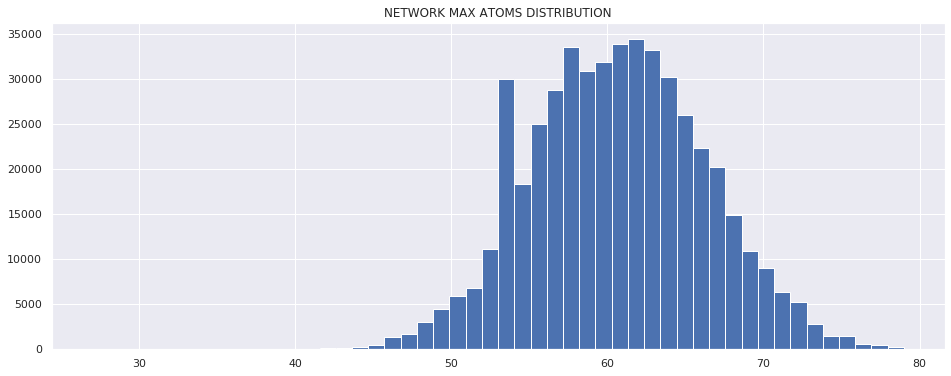

In [60]:
%matplotlib inline
plt.figure(figsize=(16,6))
plt.hist(max_atoms_list, bins = 50)
plt.title('NETWORK MAX ATOMS DISTRIBUTION')
plt.show()

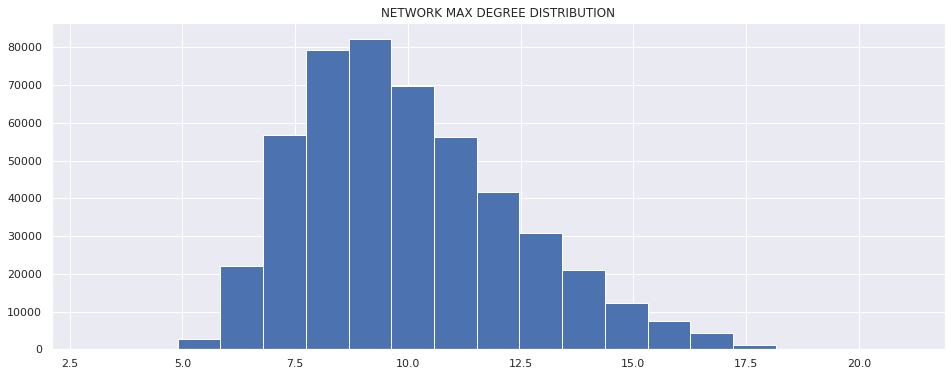

In [61]:
plt.figure(figsize=(16,6))
plt.hist(max_deg_list, bins = 19)
plt.title('NETWORK MAX DEGREE DISTRIBUTION')
plt.show()

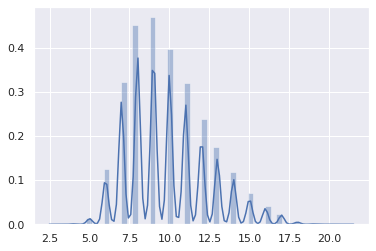

In [62]:
sns.distplot(max_deg_list)

# Running the SeqVeq model to create encodings for each protein available

In [10]:
model_dir = Path('/home/rootlocus/Desktop/NTUA/Systems_Biology_Lab/DiplomaThesis/DiplomaAutoencoder/models/uniref50_v2')
weights = model_dir/'weights.hdf5'
options = model_dir/'options.json'
seqveq = ElmoEmbedder(options_file=options, weight_file=weights, cuda_device=0)

In [64]:
proteins_path = Path('../datasets/proteins.csv')
proteins = pd.read_csv(proteins_path, index_col=0)
proteins = proteins.drop(['id'], axis=1)
seq_ind = proteins.sequences.str.len().sort_values().index
proteins = proteins.reindex(seq_ind)
proteins

,gene,sequences,prot_length
3698,PLN,MEKVQYLTRSAIRRASTIEMPQQARQKLQNLFINFCLILICLLLIC...,52
949,PMAIP1,MPGKKARKNAQPSPARAPAELEVECATQLRRFGDKLNFRQKLLNLI...,54
1383,MIR22HG,MGWEGPNSRVDDTFWASWRAFAQIGPARSGFRLETLAGLRSRRLKQ...,57
3080,MT2A,MDPNCSCAAGDSCTCAGSCKCKECKCTSCKKSCCSCCPVGCAKCAQ...,61
2761,POLR2L,MIIPVRCFTCGKIVGNKWEAYLGLLQAEYTEGDALDALGLKRYCCR...,67
...,...,...,...
2640,RYR1,MGDAEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRLC...,5038
3797,USH2A,MNCPVLSLGSGFLFQVIEMLIFAYFASISLTESRGLFPRLENVGAF...,5202
1256,KMT2D,MDSQKLAGEDKDSEPAADGPAASEDPSATESDLPNPHVGEVSVLSS...,5537
3322,MUC5AC,MSVGRRKLALLWALALALACTRHTGHAQDGSSESSYKHHPALSPIA...,5654


In [12]:
seqs = pd.Series.to_numpy(proteins.sequences)
#seqs = [*map(list, seqs)]

In [235]:
def make_embedding(seq):
    emb = seqveq.embed_sentence(list(seq))
    emb = np.sum(emb, axis=0)
    emb = np.mean(emb, axis=0)
    print(f'Current Protein Length: {len(seq)}')
    return emb

In [62]:
def create_embeddings():
    embeddings = [*map(make_embedding, seqs)]
    embds = [*map(list, embeddings)]
    proteins['seq_embedding'] = embds
    proteins.to_csv('../datasets/proteins_sorted_embedded.csv')

In [15]:
prot_dict = defaultdict(list)
prots = pd.read_csv('../datasets/proteins_sorted_embedded.csv')
prots = prots[['gene','seq_embedding']].sort_index()

for idx, prot_emb in enumerate(prots['seq_embedding']):
    print(f'Currently in protein: {idx}')
    prot_emb = ast.literal_eval(prot_emb)
    prots['seq_embedding'][idx] = prot_emb

Currently in protein: 0
Currently in protein: 1
Currently in protein: 2
Currently in protein: 3
Currently in protein: 4
Currently in protein: 5
Currently in protein: 6
Currently in protein: 7
Currently in protein: 8
Currently in protein: 9
Currently in protein: 10
Currently in protein: 11
Currently in protein: 12
Currently in protein: 13
Currently in protein: 14
Currently in protein: 15
Currently in protein: 16
Currently in protein: 17
Currently in protein: 18
Currently in protein: 19
Currently in protein: 20
Currently in protein: 21
Currently in protein: 22
Currently in protein: 23
Currently in protein: 24
Currently in protein: 25
Currently in protein: 26
Currently in protein: 27
Currently in protein: 28
Currently in protein: 29
Currently in protein: 30
Currently in protein: 31
Currently in protein: 32
Currently in protein: 33
Currently in protein: 34
Currently in protein: 35
Currently in protein: 36
Currently in protein: 37
Currently in protein: 38
Currently in protein: 39
Currently 

Currently in protein: 365
Currently in protein: 366
Currently in protein: 367
Currently in protein: 368
Currently in protein: 369
Currently in protein: 370
Currently in protein: 371
Currently in protein: 372
Currently in protein: 373
Currently in protein: 374
Currently in protein: 375
Currently in protein: 376
Currently in protein: 377
Currently in protein: 378
Currently in protein: 379
Currently in protein: 380
Currently in protein: 381
Currently in protein: 382
Currently in protein: 383
Currently in protein: 384
Currently in protein: 385
Currently in protein: 386
Currently in protein: 387
Currently in protein: 388
Currently in protein: 389
Currently in protein: 390
Currently in protein: 391
Currently in protein: 392
Currently in protein: 393
Currently in protein: 394
Currently in protein: 395
Currently in protein: 396
Currently in protein: 397
Currently in protein: 398
Currently in protein: 399
Currently in protein: 400
Currently in protein: 401
Currently in protein: 402
Currently in

Currently in protein: 771
Currently in protein: 772
Currently in protein: 773
Currently in protein: 774
Currently in protein: 775
Currently in protein: 776
Currently in protein: 777
Currently in protein: 778
Currently in protein: 779
Currently in protein: 780
Currently in protein: 781
Currently in protein: 782
Currently in protein: 783
Currently in protein: 784
Currently in protein: 785
Currently in protein: 786
Currently in protein: 787
Currently in protein: 788
Currently in protein: 789
Currently in protein: 790
Currently in protein: 791
Currently in protein: 792
Currently in protein: 793
Currently in protein: 794
Currently in protein: 795
Currently in protein: 796
Currently in protein: 797
Currently in protein: 798
Currently in protein: 799
Currently in protein: 800
Currently in protein: 801
Currently in protein: 802
Currently in protein: 803
Currently in protein: 804
Currently in protein: 805
Currently in protein: 806
Currently in protein: 807
Currently in protein: 808
Currently in

Currently in protein: 1177
Currently in protein: 1178
Currently in protein: 1179
Currently in protein: 1180
Currently in protein: 1181
Currently in protein: 1182
Currently in protein: 1183
Currently in protein: 1184
Currently in protein: 1185
Currently in protein: 1186
Currently in protein: 1187
Currently in protein: 1188
Currently in protein: 1189
Currently in protein: 1190
Currently in protein: 1191
Currently in protein: 1192
Currently in protein: 1193
Currently in protein: 1194
Currently in protein: 1195
Currently in protein: 1196
Currently in protein: 1197
Currently in protein: 1198
Currently in protein: 1199
Currently in protein: 1200
Currently in protein: 1201
Currently in protein: 1202
Currently in protein: 1203
Currently in protein: 1204
Currently in protein: 1205
Currently in protein: 1206
Currently in protein: 1207
Currently in protein: 1208
Currently in protein: 1209
Currently in protein: 1210
Currently in protein: 1211
Currently in protein: 1212
Currently in protein: 1213
C

Currently in protein: 1612
Currently in protein: 1613
Currently in protein: 1614
Currently in protein: 1615
Currently in protein: 1616
Currently in protein: 1617
Currently in protein: 1618
Currently in protein: 1619
Currently in protein: 1620
Currently in protein: 1621
Currently in protein: 1622
Currently in protein: 1623
Currently in protein: 1624
Currently in protein: 1625
Currently in protein: 1626
Currently in protein: 1627
Currently in protein: 1628
Currently in protein: 1629
Currently in protein: 1630
Currently in protein: 1631
Currently in protein: 1632
Currently in protein: 1633
Currently in protein: 1634
Currently in protein: 1635
Currently in protein: 1636
Currently in protein: 1637
Currently in protein: 1638
Currently in protein: 1639
Currently in protein: 1640
Currently in protein: 1641
Currently in protein: 1642
Currently in protein: 1643
Currently in protein: 1644
Currently in protein: 1645
Currently in protein: 1646
Currently in protein: 1647
Currently in protein: 1648
C

Currently in protein: 1934
Currently in protein: 1935
Currently in protein: 1936
Currently in protein: 1937
Currently in protein: 1938
Currently in protein: 1939
Currently in protein: 1940
Currently in protein: 1941
Currently in protein: 1942
Currently in protein: 1943
Currently in protein: 1944
Currently in protein: 1945
Currently in protein: 1946
Currently in protein: 1947
Currently in protein: 1948
Currently in protein: 1949
Currently in protein: 1950
Currently in protein: 1951
Currently in protein: 1952
Currently in protein: 1953
Currently in protein: 1954
Currently in protein: 1955
Currently in protein: 1956
Currently in protein: 1957
Currently in protein: 1958
Currently in protein: 1959
Currently in protein: 1960
Currently in protein: 1961
Currently in protein: 1962
Currently in protein: 1963
Currently in protein: 1964
Currently in protein: 1965
Currently in protein: 1966
Currently in protein: 1967
Currently in protein: 1968
Currently in protein: 1969
Currently in protein: 1970
C

Currently in protein: 2376
Currently in protein: 2377
Currently in protein: 2378
Currently in protein: 2379
Currently in protein: 2380
Currently in protein: 2381
Currently in protein: 2382
Currently in protein: 2383
Currently in protein: 2384
Currently in protein: 2385
Currently in protein: 2386
Currently in protein: 2387
Currently in protein: 2388
Currently in protein: 2389
Currently in protein: 2390
Currently in protein: 2391
Currently in protein: 2392
Currently in protein: 2393
Currently in protein: 2394
Currently in protein: 2395
Currently in protein: 2396
Currently in protein: 2397
Currently in protein: 2398
Currently in protein: 2399
Currently in protein: 2400
Currently in protein: 2401
Currently in protein: 2402
Currently in protein: 2403
Currently in protein: 2404
Currently in protein: 2405
Currently in protein: 2406
Currently in protein: 2407
Currently in protein: 2408
Currently in protein: 2409
Currently in protein: 2410
Currently in protein: 2411
Currently in protein: 2412
C

Currently in protein: 2803
Currently in protein: 2804
Currently in protein: 2805
Currently in protein: 2806
Currently in protein: 2807
Currently in protein: 2808
Currently in protein: 2809
Currently in protein: 2810
Currently in protein: 2811
Currently in protein: 2812
Currently in protein: 2813
Currently in protein: 2814
Currently in protein: 2815
Currently in protein: 2816
Currently in protein: 2817
Currently in protein: 2818
Currently in protein: 2819
Currently in protein: 2820
Currently in protein: 2821
Currently in protein: 2822
Currently in protein: 2823
Currently in protein: 2824
Currently in protein: 2825
Currently in protein: 2826
Currently in protein: 2827
Currently in protein: 2828
Currently in protein: 2829
Currently in protein: 2830
Currently in protein: 2831
Currently in protein: 2832
Currently in protein: 2833
Currently in protein: 2834
Currently in protein: 2835
Currently in protein: 2836
Currently in protein: 2837
Currently in protein: 2838
Currently in protein: 2839
C

Currently in protein: 3155
Currently in protein: 3156
Currently in protein: 3157
Currently in protein: 3158
Currently in protein: 3159
Currently in protein: 3160
Currently in protein: 3161
Currently in protein: 3162
Currently in protein: 3163
Currently in protein: 3164
Currently in protein: 3165
Currently in protein: 3166
Currently in protein: 3167
Currently in protein: 3168
Currently in protein: 3169
Currently in protein: 3170
Currently in protein: 3171
Currently in protein: 3172
Currently in protein: 3173
Currently in protein: 3174
Currently in protein: 3175
Currently in protein: 3176
Currently in protein: 3177
Currently in protein: 3178
Currently in protein: 3179
Currently in protein: 3180
Currently in protein: 3181
Currently in protein: 3182
Currently in protein: 3183
Currently in protein: 3184
Currently in protein: 3185
Currently in protein: 3186
Currently in protein: 3187
Currently in protein: 3188
Currently in protein: 3189
Currently in protein: 3190
Currently in protein: 3191
C

Currently in protein: 3535
Currently in protein: 3536
Currently in protein: 3537
Currently in protein: 3538
Currently in protein: 3539
Currently in protein: 3540
Currently in protein: 3541
Currently in protein: 3542
Currently in protein: 3543
Currently in protein: 3544
Currently in protein: 3545
Currently in protein: 3546
Currently in protein: 3547
Currently in protein: 3548
Currently in protein: 3549
Currently in protein: 3550
Currently in protein: 3551
Currently in protein: 3552
Currently in protein: 3553
Currently in protein: 3554
Currently in protein: 3555
Currently in protein: 3556
Currently in protein: 3557
Currently in protein: 3558
Currently in protein: 3559
Currently in protein: 3560
Currently in protein: 3561
Currently in protein: 3562
Currently in protein: 3563
Currently in protein: 3564
Currently in protein: 3565
Currently in protein: 3566
Currently in protein: 3567
Currently in protein: 3568
Currently in protein: 3569
Currently in protein: 3570
Currently in protein: 3571
C

In [16]:
for prot, emb in zip(prots['gene'], prots['seq_embedding']):
    prot_dict[prot] = emb

In [17]:
with open('prot_embs.pickle', 'wb') as f:
    pickle.dump(prot_dict, f)

In [18]:
prots = {}
if os.path.exists('prot_embs.pickle'):
    print('Exists')
    with open('prot_embs.pickle', 'rb') as f:
        unpickler = pickle.Unpickler(f)
        prots = unpickler.load()
    print('Unpickled')

Exists
Unpickled


## Multiple Factor Analysis for the protein features using prince

In [4]:
# marking the dataset paths

mf_path = '../datasets/mf_features.csv'
bp_path = '../datasets/bp_features.csv'
cc_path = '../datasets/cc_features.csv'

mf_feats = pd.read_csv(mf_path, index_col=0)
bp_feats = pd.read_csv(bp_path, index_col=0)
cc_feats = pd.read_csv(cc_path, index_col=0)

In [5]:
bp_feats.columns = [f'V{i}' for i in range(1,1040)]
mf_feats.columns = [f'V{i}' for i in range(1040,1040+142)]
cc_feats.columns = [f'V{i}' for i in range(1182,1182+156)]

In [6]:
joint = bp_feats.join(mf_feats)
joint = joint.join(cc_feats)
joint.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V1328', 'V1329', 'V1330', 'V1331', 'V1332', 'V1333', 'V1334', 'V1335',
       'V1336', 'V1337'],
      dtype='object', length=1337)

In [7]:
# Create the groups for Multiple Factor Analysis
groups = {
    'bp_features':[f'V{i}' for i in range (1,1040)],
    'mf_features':[f'V{i}' for i in range(1040, 1040+142)],
    'cc_features':[f'V{i}' for i in range(1182, 1182+156)]
}

In [8]:
# Initializing MFA object
mfa = MFA(
    groups=groups,
    n_components=100,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
    )

mfa = mfa.fit(joint)

In [175]:
mfa.transform(joint)

array([[-2.94357249,  2.49905443,  1.99305179, ..., -0.70416222,
        -0.45773123, -0.07804728],
       [-2.91348926,  1.08897108,  1.02906947, ..., -0.10992653,
         0.21711846, -0.4936749 ],
       [ 0.6344046 ,  1.99049857,  0.66283498, ...,  0.42911706,
        -0.2689531 ,  0.27828225],
       ...,
       [-2.17286069,  0.7359359 ,  1.27439806, ...,  0.03940549,
        -0.28528574,  0.44631273],
       [-1.60712866,  0.92122095,  1.88128672, ...,  0.11561968,
        -0.13125757, -0.08767881],
       [-2.82828634,  1.36845979,  2.0510995 , ..., -0.59154955,
         0.46324244, -0.07862911]])

## Choose number of principal components based on explained variance

In [9]:
# Choosing 350 components explaining about 85% of the variance
n = 350
mfa = MFA(
        groups=groups,
        n_components=n,
        n_iter=10,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42
    )
mfa = mfa.fit(joint)

In [10]:
reduced_feats = mfa.fit_transform(joint)

In [12]:
scaler = StandardScaler()
reduced_feats = scaler.fit_transform(reduced_feats)

In [13]:
index_map = joint.index.to_numpy()
len(index_map)

3802

In [19]:
for idx,prot in enumerate(index_map):
    prots[prot] = np.concatenate((np.array(prots[prot]), reduced_feats[idx]), axis=None)

In [20]:
with open('prot_embs_w_go.pickle', 'wb') as f:
    pickle.dump(prots, f)

In [21]:
prots['LCK']

array([ 0.10792818, -0.00361283, -0.03308113, ..., -1.34502566,
        1.27002239,  0.7231859 ])